# Librerias

In [16]:
#!pip install pandas matplotlib prophet
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from google.cloud import bigquery
from datetime import datetime, timedelta
import warnings
import os
warnings.simplefilter("ignore")
import logging

# Configurar el registro para suprimir mensajes INFO
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Funciones de Lectura

In [3]:
def Ventas_Diarias(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
    SELECT *
    FROM `inretail-negocios-sd.intercorpretail.JFV_VENTAS_TIENDAS_MASS` 
    WHERE CODIGO_LOCAL IN (
     SELECT CODIGO_LOCAL
    FROM (
    SELECT codigo_local,max(difdias) DIAS
       FROM `inretail-negocios-sd.intercorpretail.JFV_VENTAS_TIENDAS_MASS` 
       group by codigo_local
    )
    WHERE DIAS>2
    )

   """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 

def Antiguedad_Tiendas(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
    SELECT *   
    FROM 
    (SELECT codigo_local,max(difdias) DIAS
       FROM `inretail-negocios-sd.intercorpretail.JFV_VENTAS_TIENDAS_MASS` 
       group by codigo_local)
    WHERE CODIGO_LOCAL NOT IN 
    (
    SELECT 
        a.codigo_local
        FROM (
        SELECT

        codigo_local,Local,avg(Total) Venta_Promedio,avg(Transacciones)TXS_PROM,
                           max(Mes) Antiguedad,max(Apertura) Apertura , max(Fecha) Ult_Vta

        FROM (
        SELECT 
        codigo_local,Formato,REPLACE(REPLACE(Local,"ñ","n"),"Ñ","N")Local,A__o,Nombre_Mes,Total,REPLACE(REPLACE(nombre_ant,"ñ","n"),"Ñ","N") nombre_ant,fecha,Apertura,
        Mes,Transacciones
        FROM 
        inretail-negocios-sd.intercorpretail_mass.DS_Mass_02_Ventas_DEV_v01_PRE
        WHERE CODIGO_LOCAL NOT IN (SELECT  codigo_local FROM  inretail-negocios-sd.intercorpretail_mass.Tabla_Estacionalidad_Prueba WHERE STATUS='Activo')
        )
        GROUP BY CODIGO_LOCAL,Local
        ORDER BY Ult_Vta desc )A 
        LEFT join inretail-negocios-sd.intercorpretail_mass.Maestro_Ubicacion_Tiendas_Mass  B on a.codigo_local=b.codigo_local
        Where Longitud is not null
    )
    
     """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 

def Ventas_Mensuales(Llave):
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
    client = bigquery.Client()
    sql = """
    SELECT *,row_number()over(partition by codigo_local order by periodo asc) Mes
    FROM inretail-negocios-sd.intercorpretail_mass.Ventas_Tiendas_Mass_Estacionalidad
    WHERE PERIODO!=(SELECT MAX(PERIODO) FROM inretail-negocios-sd.intercorpretail_mass.Ventas_Tiendas_Mass_Estacionalidad)
    ORDER BY CODIGO_LOCAL ASC 
     """
    Ventas_Anho_Operacion = client.query(sql).to_dataframe()
    return Ventas_Anho_Operacion 

def Cargas_Datos_Bigquery(DataFrame,Nombre_Tabla):
    client = bigquery.Client()
    nombre_tabla_f = 'inretail-negocios-sd.intercorpretail_mass.'
    nombre_tabla_f=nombre_tabla_f+Nombre_Tabla

    job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE",)
    
    job = client.load_table_from_dataframe(
        DataFrame, nombre_tabla_f, job_config=job_config
    )
    print('Resultados cargados en la tabla :', nombre_tabla_f)
    return True

def Cargas_Datos_Bigquery_Apendar(DataFrame,Nombre_Tabla):
    client = bigquery.Client()
    nombre_tabla_f = 'inretail-negocios-sd.intercorpretail_mass.'
    nombre_tabla_f=nombre_tabla_f+Nombre_Tabla

    job_config = bigquery.LoadJobConfig(write_disposition="WRITE_APPEND",)
    
    job = client.load_table_from_dataframe(
        DataFrame, nombre_tabla_f, job_config=job_config
    )
    #print('Resultados cargados en la tabla :', nombre_tabla_f)
    return True

In [4]:
Ruta_Inicial=os.getcwd()
Ruta_Inicial

'/home/jorge_fernandez/entorno_ic_python'

In [5]:
os.chdir(Ruta_Inicial)
ruta=Ruta_Inicial.replace("\\","/")
Llave=[s for s in os.listdir(ruta) if any(xs in s for xs in ['.json'])][0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = Llave
client = bigquery.Client()

In [6]:
Ventas=Ventas_Diarias(Llave)
Antiguedad_Tiendas_TB=Antiguedad_Tiendas(Llave)
Ventas_Historicas=Ventas_Mensuales(Llave)

In [7]:
Tiendas_Maduras=Antiguedad_Tiendas_TB[Antiguedad_Tiendas_TB['DIAS']>=365]
Tiendas_Nuevas=Antiguedad_Tiendas_TB[Antiguedad_Tiendas_TB['DIAS']<365]
print("Tiendas Maduras: ",len(Tiendas_Maduras.codigo_local.unique()))
print("Tiendas con menos de 1 año: ",len(Tiendas_Nuevas.codigo_local.unique()))
print("Tiendas con menos de 1 semana : ",len(Tiendas_Nuevas[Tiendas_Nuevas['DIAS']<7].codigo_local.unique()))

Tiendas Maduras:  752
Tiendas con menos de 1 año:  319
Tiendas con menos de 1 semana :  3


In [8]:
Ventas_Historicas
Ventas_Diarias_Maduras=Ventas[Ventas['codigo_local'].isin(Tiendas_Maduras.codigo_local.unique())==True]
Ventas_Diarias_Nuevas=Ventas[Ventas['codigo_local'].isin(Tiendas_Nuevas.codigo_local.unique())==True]
Ventas_Diarias_Maduras['fecha'] = pd.to_datetime(Ventas_Diarias_Maduras['fecha'])

In [9]:
Ventas_Diarias_Maduras[Ventas_Diarias_Maduras['codigo_local']=='1000']

,codigo_local,fecha,Venta,Tienda,fechamin,DifDias
161143,1000,2021-05-25,2052.81,VillaT 5 LO MS,2021-04-26,30
161144,1000,2021-07-04,2557.07,VillaT 5 LO MS,2021-04-26,70
161145,1000,2022-04-04,3271.00,VillaT 5 LO MS,2021-04-26,342
161146,1000,2023-06-05,4485.29,VillaT 5 LO MS,2021-04-26,767
161147,1000,2023-11-01,5012.62,VillaT 5 LO MS,2021-04-26,916
...,...,...,...,...,...,...
786976,1000,2024-02-06,4618.83,VillaT 5 LO MS,2021-04-26,1012
786977,1000,2024-06-04,3732.89,VillaT 5 LO MS,2021-04-26,1131
786978,1000,2022-02-23,2765.36,VillaT 5 LO MS,2021-04-26,302
786979,1000,2022-08-17,4192.64,VillaT 5 LO MS,2021-04-26,476


In [10]:
def actualizar_graficos_nuevas(codigo_local):
    #clear_output(wait=True)  # Borrar la salida anterior
    # Filtrar datos según el código local
    daily_sales = Ventas_Diarias_Nuevas[Ventas_Diarias_Nuevas['codigo_local'] == codigo_local]
    daily_sales = daily_sales.sort_values('fecha', ascending=True)
    monthly_sales = Ventas_Historicas[Ventas_Historicas['codigo_local'] == codigo_local]

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    # Gráfico de ventas diarias
    ax[0].plot(daily_sales['fecha'], daily_sales['Venta'], marker='o')
    ax[0].set_title('Tendencia de Ventas Diarias')
    ax[0].set_xlabel('Fecha')
    ax[0].set_ylabel('Venta')
    ax[0].tick_params(axis='x', rotation=45)

    # Gráfico de ventas mensuales
    ax[1].plot(monthly_sales['Mes'], monthly_sales['Venta'], marker='o')
    ax[1].set_title('Ventas Mensuales')
    ax[1].set_xlabel('Mes')
    ax[1].set_ylabel('Venta')
    
    plt.tight_layout()
    plt.show()

# Crear widgets
codigo_locales_unicos = list(Ventas_Diarias_Nuevas['codigo_local'].unique())
codigo_local_widget = widgets.Dropdown(options=codigo_locales_unicos, description='Código Local:  ')
 
# Interact
interact(actualizar_graficos_nuevas, codigo_local=codigo_local_widget);

interactive(children=(Dropdown(description='Código Local:  ', options=('1577', '1752', '1759', '1783', '1724',…

In [11]:
def actualizar_graficos(codigo_local):
    #}clear_output(wait=True)  # Borrar la salida anterior
    # Filtrar datos según el código local
    daily_sales = Ventas_Diarias_Maduras[Ventas_Diarias_Maduras['codigo_local'] == codigo_local]
    daily_sales = daily_sales.sort_values('fecha', ascending=True)
    monthly_sales = Ventas_Historicas[Ventas_Historicas['codigo_local'] == codigo_local]

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    # Gráfico de ventas diarias
    ax[0].plot(daily_sales['fecha'], daily_sales['Venta'], marker='o')
    ax[0].set_title('Tendencia de Ventas Diarias')
    ax[0].set_xlabel('Fecha')
    ax[0].set_ylabel('Venta')
    ax[0].tick_params(axis='x', rotation=45)

    # Gráfico de ventas mensuales
    ax[1].plot(monthly_sales['Mes'], monthly_sales['Venta'], marker='o')
    ax[1].set_title('Ventas Mensuales')
    ax[1].set_xlabel('Mes')
    ax[1].set_ylabel('Venta')
    
    plt.tight_layout()
    plt.show()

# Crear widgets
codigo_locales_unicos = list(Ventas_Diarias_Maduras['codigo_local'].unique())
codigo_local_widget = widgets.Dropdown(options=codigo_locales_unicos, description='Código Local:  ')
 
# Interact
interact(actualizar_graficos, codigo_local=codigo_local_widget);

interactive(children=(Dropdown(description='Código Local:  ', options=('M244', 'M293', 'M729', '1219', '1452',…

In [12]:
Ventas_Historicas

,codigo_local,Formato,Anho,Nombre_Mes,Venta,TXs,Periodo,Mes
0,1000,MASS,2021,Abr,5204.59,356,202104,1
1,1000,MASS,2021,May,61578.11,3778,202105,2
2,1000,MASS,2021,Jun,70509.61,4428,202106,3
3,1000,MASS,2021,Jul,86230.94,5263,202107,4
4,1000,MASS,2021,Ago,68548.59,4512,202108,5
...,...,...,...,...,...,...,...,...
41877,M890,MASS,2024,Feb,161675.88,12266,202402,39
41878,M890,MASS,2024,Mar,168798.41,12277,202403,40
41879,M890,MASS,2024,Abr,161010.72,11866,202404,41
41880,M890,MASS,2024,May,158062.23,11676,202405,42


In [13]:
from datetime import datetime
current_datetime = datetime.now()
current_datetime
print(current_datetime)

2024-07-14 11:36:04.713571


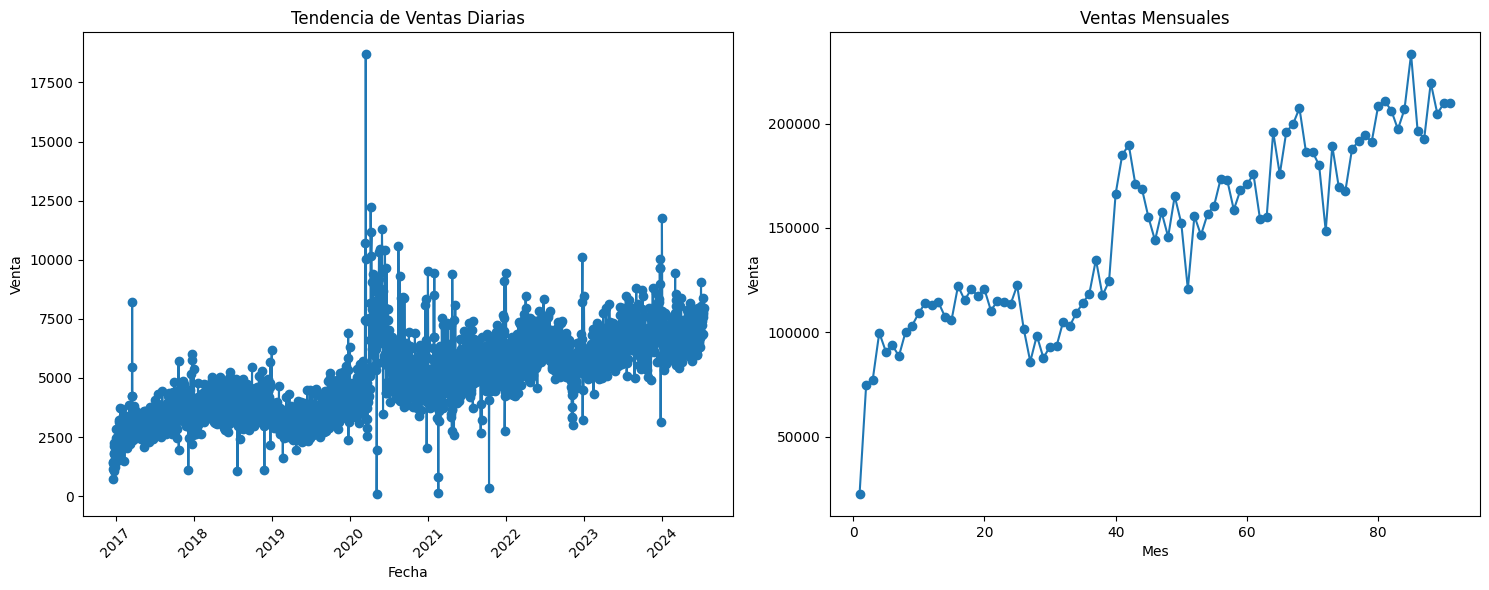

In [14]:
codigo_local='M293'
Tienda_Madura=Ventas_Diarias_Maduras[Ventas_Diarias_Maduras['codigo_local'] == codigo_local]
Tienda_Madura=Tienda_Madura.sort_values('fecha', ascending=True)
monthly_sales = Ventas_Historicas[Ventas_Historicas['codigo_local'] == codigo_local]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# Gráfico de ventas diarias
ax[0].plot(Tienda_Madura['fecha'], Tienda_Madura['Venta'], marker='o')
ax[0].set_title('Tendencia de Ventas Diarias')
ax[0].set_xlabel('Fecha')
ax[0].set_ylabel('Venta')
ax[0].tick_params(axis='x', rotation=45)

# Gráfico de ventas mensuales
ax[1].plot(monthly_sales['Mes'], monthly_sales['Venta'], marker='o')
ax[1].set_title('Ventas Mensuales')
ax[1].set_xlabel('Mes')
ax[1].set_ylabel('Venta')

plt.tight_layout()
plt.show()


In [ ]:
current_year = datetime.now().year
start_date = datetime(current_year, 1, 2)
ultima_fecha_actual=datetime.now()- timedelta(days=1)
date_range = pd.date_range(start=start_date, end=ultima_fecha_actual)

#codigo_local='M293'
Tienda_maduras=list(Ventas_Diarias_Maduras['codigo_local'].unique())
print(len(Tienda_maduras))

for codigo_local in Tienda_maduras:
    print(codigo_local)
    resultados = []
    Tienda_Madura=Ventas_Diarias_Maduras[Ventas_Diarias_Maduras['codigo_local'] == codigo_local]
    for date in date_range:
        Data_Predecir = Tienda_Madura[Tienda_Madura['fecha'] < date]
        df=Data_Predecir[['fecha','Venta']]
        df.columns = ['ds', 'y']
        
        model = Prophet(
                yearly_seasonality=False,
                weekly_seasonality=True,
                daily_seasonality=True,
                seasonality_mode='multiplicative',  # Cambiar a 'additive' si es necesario
            )
            
        model.fit(df)
        future = model.make_future_dataframe(periods=365)
        forecast = model.predict(future)
        
        current_year = datetime.now().year
        current_year_data = forecast[forecast['ds'].dt.year == current_year]
        current_year_data['month_year'] = current_year_data['ds'].dt.to_period('M')
        monthly_sales_current_year = current_year_data.groupby('month_year')['yhat'].sum().reset_index()
        monthly_sales_current_year.columns = ['Month', 'Total_Venta']
        monthly_sales_current_year = monthly_sales_current_year.set_index('Month').T
        monthly_sales_current_year.columns =['ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']
        monthly_sales_current_year=monthly_sales_current_year.reset_index().drop('index',axis=1)
        monthly_sales_current_year['codigo_local']=codigo_local
        monthly_sales_current_year['fecha_ejec']=date
        resultados.append(monthly_sales_current_year)
    final_result = pd.concat(resultados, ignore_index=True)
    Cargas_Datos_Bigquery_Apendar(final_result,"Forecast_Tiendas_Maduras_Profhet_F")

752
M244
M293
M729
1219
1452
M380
M473
1048
1409
1221
1319
M309
1197
1218
M387
1092
1411
M306
M777
M386
M616
M618
M647
1412
M389
M391
M622
M642
M464
M476
1085
1088
1417
M240
M314
M472
M480
1226
1239
1343
M305
M312
M313
M479
1358
1454
1455
1082
1090
1096
1236
M728
1203
M725
1066
1081
1087
1094
1098
M831
1209
M381
1229
M356
1217
M245
1086
M481
1215
1421
M722
M737
M727
1214
M393
M395
M396
M730
1447
1458
1106
1231
1176
1206
1225
1228
1233
1241
M783
1121
1446
M734
1099
1291
1322
M488
M740
M785
M788
M794
1114
M394
1089
M475
M487
M639
M640
M646
M652
M657
M658
M663
M792
M793
1237
1238
1469
M388
M661
M733
M743
1208
M490
M493
M664
M735
M745
M796
M800
1093
1481
M398
M795
M797
1030
1091
1120
1152
M310
M497
M660
M665
1105
1462
1482
M485
M489
1133
1138
1149
1154
1244
M283
1111
1127
1137
1141
1150
1153
1352
1435
1084
1123
1139
M401
M742
1014
1095
1100
1108
1112
1117
1126
1129
1132
1134
1136
M319
M780
1046
1083
1109
M399
M662
1201
1240
1246
1262
M040
M079
M739
M741
M746
M747
M749
M750
M753
1230
M272
1

In [101]:
final_result = pd.concat(resultados, ignore_index=True)
final_result.to_csv('Prueba1.csv',index=False)

In [94]:
current_year = datetime.now().year
current_year_data = forecast[forecast['ds'].dt.year == current_year]
current_year_data['month_year'] = current_year_data['ds'].dt.to_period('M')
monthly_sales_current_year = current_year_data.groupby('month_year')['yhat'].sum().reset_index()
monthly_sales_current_year.columns = ['Month', 'Total_Venta']
monthly_sales_current_year = monthly_sales_current_year.set_index('Month').T
monthly_sales_current_year.columns =['ENE','FEB','MAR','ABR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']
monthly_sales_current_year=monthly_sales_current_year.reset_index().drop('index',axis=1)
monthly_sales_current_year['codigo_local']=codigo_local
monthly_sales_current_year['fecha_ejec']=date
monthly_sales_current_year

,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC,codigo_local,fecha_ejec
0,216095.402357,204262.884514,222042.218472,216084.547875,224001.256403,222067.753953,229521.04967,232430.822707,227819.837442,235555.44028,231975.063598,241879.742327,M293,2024-01-02


In [90]:
monthly_sales_transposed

Month,2024-01,2024-02,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
Total_Venta,216095.402357,204262.884514,222042.218472,216084.547875,224001.256403,222067.753953,229521.04967,232430.822707,227819.837442,235555.44028,231975.063598,241879.742327


In [109]:
from multiprocessing import Pool, cpu_count

def procesar_tienda(codigo_local, date_range, Ventas_Diarias_Maduras):
    resultados = []
    Tienda_Madura = Ventas_Diarias_Maduras[Ventas_Diarias_Maduras['codigo_local'] == codigo_local]
    
    for date in date_range:
        Data_Predecir = Tienda_Madura[Tienda_Madura['fecha'] < date]
        df = Data_Predecir[['fecha', 'Venta']].copy()
        df.columns = ['ds', 'y']
        
        model = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=True,
            daily_seasonality=True,
            seasonality_mode='multiplicative',  # Cambiar a 'additive' si es necesario
        )
        
        model.fit(df)
        future = model.make_future_dataframe(periods=365)
        forecast = model.predict(future)
        
        current_year = datetime.now().year
        current_year_data = forecast[forecast['ds'].dt.year == current_year]
        current_year_data['month_year'] = current_year_data['ds'].dt.to_period('M')
        monthly_sales_current_year = current_year_data.groupby('month_year')['yhat'].sum().reset_index()
        monthly_sales_current_year.columns = ['Month', 'Total_Venta']
        monthly_sales_current_year = monthly_sales_current_year.set_index('Month').T
        monthly_sales_current_year.columns = ['ENE', 'FEB', 'MAR', 'ABR', 'MAY', 'JUN', 'JUL', 'AGO', 'SEP', 'OCT', 'NOV', 'DIC']
        monthly_sales_current_year = monthly_sales_current_year.reset_index(drop=True)
        monthly_sales_current_year['codigo_local'] = codigo_local
        monthly_sales_current_year['fecha_ejec'] = date
        resultados.append(monthly_sales_current_year)
    
    return resultados

def main():
    # Supongo que Ventas_Diarias_Maduras es un DataFrame previamente cargado
    current_year = datetime.now().year
    start_date = datetime(current_year, 1, 2)
    ultima_fecha_actual = datetime.now() - timedelta(days=1)
    date_range = pd.date_range(start=start_date, end=ultima_fecha_actual)

    Tienda_maduras = list(Ventas_Diarias_Maduras['codigo_local'].unique())
    print(f"Total tiendas maduras: {len(Tienda_maduras)}")

    # Usar Pool para paralelizar el procesamiento de cada tienda
    num_workers = min(cpu_count(), len(Tienda_maduras))
    with Pool(num_workers) as pool:
        resultados = pool.starmap(procesar_tienda, [(codigo_local, date_range, Ventas_Diarias_Maduras) for codigo_local in Tienda_maduras])
    
    # Flatten the list of results
    resultados_flat = [item for sublist in resultados for item in sublist]
    
    # Convert to DataFrame
    resultados_df = pd.concat(resultados_flat, ignore_index=True)
    print(resultados_df)

if __name__ == '__main__':
    main()

Total tiendas maduras: 876


16:11:13 - cmdstanpy - INFO - Chain [1] start processing
16:11:13 - cmdstanpy - INFO - Chain [1] start processing
16:11:13 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:14 - cmdstanpy - INFO - Chain [1] done processing
16:11:14 - cmdstanpy - INFO - Chain [1] start processing
16:11:15 - cmdstanpy - INFO - Chain [1] start processing
16:11:15 - cmdstanpy - INFO - Chain [1] start processing
16:11:15 - cmdstanpy - INFO - Chain [1] done processing
16:11:15 - cmdstanpy - INFO - Chain [1] done processing
16:11:15 - cmdstanpy - INFO - Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
16:11:16 - cmdstanpy - INFO - Chain [1] start processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
16:11:16 - cmdstanpy - INFO - Chain [1] done processing
16:11:16 - cmdstanpy - INFO - Chain [1]

KeyboardInterrupt: 

In [111]:
len(resultados)

728

In [113]:
final_result

,ENE,FEB,MAR,ABR,MAY,JUN,JUL,AGO,SEP,OCT,NOV,DIC,codigo_local,fecha_ejec
0,216095.402357,204262.884514,222042.218472,216084.547875,224001.256403,222067.753953,229521.049670,232430.822707,227819.837442,235555.440280,231975.063598,234353.708231,M293,2024-01-02
1,209440.562660,204841.461808,222732.809669,216819.083074,224818.725440,222939.592514,230483.164940,233461.974388,228888.917016,236720.476548,233175.512524,243192.326739,M293,2024-01-03
2,209612.004173,205010.638254,222922.348613,217007.687837,225026.419583,223147.321609,230706.354002,233688.776207,229119.070818,236967.342408,233419.229962,243452.051111,M293,2024-01-04
3,209751.984463,205164.488966,223108.342247,217214.832175,225261.878250,223395.678058,230991.710794,233995.344137,229436.341150,237321.223916,233785.321621,243851.569982,M293,2024-01-05
4,209763.524426,205184.627349,223140.194136,217251.987997,225308.746453,223453.244279,231056.227346,234069.910373,229519.543180,237412.493540,233883.556192,243963.555995,M293,2024-01-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,170748.052037,166286.033003,180803.961817,173591.811968,179438.709181,178010.381132,181480.731056,183388.617950,179619.709539,183733.931197,180525.365040,187710.969322,M310,2024-06-27
724,170636.028241,166123.609646,180582.052882,173326.205312,179107.717277,177636.335406,181046.983282,182892.815893,179089.209294,183134.586104,179891.874398,187002.520598,M310,2024-06-28
725,170579.408110,166086.942523,180562.151907,173329.140053,179130.878929,177679.000995,181112.923315,182979.275447,179193.432465,183263.047663,180036.776991,187173.566709,M310,2024-06-29
726,170586.754564,166060.423331,180495.820276,173228.219841,178990.333821,177502.974281,180895.726792,182724.089845,178905.654340,182933.072979,179678.540184,186762.424889,M310,2024-06-30


In [125]:
Ventas_Diarias_Maduras[Ventas_Diarias_Maduras['codigo_local']=='M731'].sort_values('fecha')

,codigo_local,fecha,Venta,Tienda,fechamin,DifDias
622113,M731,2019-10-07,831.61,None,2019-10-07,1
4245,M731,2019-10-08,1701.25,None,2019-10-07,2
622237,M731,2019-10-09,1774.43,None,2019-10-07,3
622071,M731,2019-10-10,1492.08,None,2019-10-07,4
622231,M731,2019-10-11,1464.47,None,2019-10-07,5
...,...,...,...,...,...,...
622093,M731,2021-12-27,3064.01,None,2019-10-07,786
4183,M731,2021-12-28,3827.27,None,2019-10-07,787
4033,M731,2021-12-29,3429.71,None,2019-10-07,788
4222,M731,2021-12-30,3941.58,None,2019-10-07,789
